# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from os import path, makedirs
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import datasets, transforms, models
from workspace_utils import active_session
import json
from PIL import Image as IM
from math import ceil

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define methods to get transforms, image datasets and data loaders

# Method to get data transforms
def get_data_transforms():
    normalize_tranform = transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    )
    rand_flip_v_transform = transforms.RandomVerticalFlip()
    rand_flip_h_transform = transforms.RandomHorizontalFlip()
    center_crop_transform = transforms.CenterCrop(224)
    resize_transform = transforms.Resize(225)
    rotation_transform = transforms.RandomRotation(180)
    tensor_transform = transforms.ToTensor()

    return {
        'train_transforms': transforms.Compose([
            resize_transform,
            center_crop_transform,
            rand_flip_h_transform,
            rand_flip_v_transform,
            rotation_transform,
            tensor_transform,
            normalize_tranform
        ]),
        'test_val_transforms': transforms.Compose([
            resize_transform,
            center_crop_transform,
            rotation_transform,
            tensor_transform,
            normalize_tranform
        ])
    }


# Method to get image datasets
def get_image_datasets(data_transforms, train_dir, valid_dir, test_dir):
    return {
        'train_data': datasets.ImageFolder(train_dir, transform=data_transforms['train_transforms']),
        'valid_data': datasets.ImageFolder(valid_dir, transform=data_transforms['test_val_transforms']),
        'test_data': datasets.ImageFolder(test_dir, transform=data_transforms['test_val_transforms']),
    }

# Method to get data loaders
def get_data_loaders(image_datasets):
    return {
        'train_loader': torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=150, shuffle=True),
        'test_loader': torch.utils.data.DataLoader(image_datasets['test_data'], batch_size=150, shuffle=True),
        'valid_loader': torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size=150, shuffle=True)
    }

In [4]:
# Define your transforms for the training, validation, and testing sets
data_transforms = get_data_transforms()

# Load the datasets with ImageFolder
image_datasets = get_image_datasets(data_transforms, train_dir, valid_dir, test_dir)

# Using the image datasets and the trainforms, define the dataloaders
data_loaders = get_data_loaders(image_datasets)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [6]:
# Method to get a model by the given architecture
def get_model(architecture = 'vgg13'):
    print('Fetching pretrained model ({})...'.format(architecture))
    model = getattr(models, architecture)(pretrained=True)
    print('Model fetched: ({}).'.format(architecture))
    return model

# Method to get the number of input features in a model's classifier
def get_num_input_features(_model_classifier):
    """
    Get the number of input_features from the classifier of the ImageNet pretrained network
    """
    if isinstance(_model_classifier, nn.Linear):
        return _model_classifier.in_features
    return [ _c for _c in _model_classifier if isinstance(_c, nn.Linear) ][0].in_features

In [7]:
# Fetch the pretrained network

# architecture = 'vgg13'
# architecture = 'densenet169'
architecture = 'densenet121'
architecture = 'alexnet'
model = get_model(architecture)

n_in_features = get_num_input_features(model.classifier)
n_out_features = len(image_datasets['test_data'].class_to_idx)
hidden_units = [1000, 500, 200] # 3 hidden layers

Fetching pretrained model (alexnet)...
Model fetched: (alexnet).


In [8]:
# Define method to freeze parameters
def freeze_parameters(_model):
    for parameter in _model.parameters():
        parameter.requires_grad = False
    print('Model parameters frozen...')

# Method to build network layer for alexnet
def for_alexnet(_n_in, _n_hid, _dropout):
    return [ nn.Dropout(_dropout), nn.Linear(_n_in, _n_hid), nn.ReLU() ]

# Method to build network layer for vgg and densenet
def for_vgg_densenet(_n_in, _n_hid, _dropout):
    return [ nn.Linear(_n_in, _n_hid), nn.ReLU(), nn.Dropout(_dropout) ]

# Define method to build a classifier
def build_classifier(_architecture, _n_in, _hidden_units, _n_out, _dropout=0.5):
    # layer_builder for the chosen architecture
    _build_layer = for_alexnet if _architecture[:7] == 'alexnet' else for_vgg_densenet
    
    # 1st hidden layer 
    _hidden_layers = _build_layer(_n_in, _hidden_units[0], _dropout)

    for _hl1, _hl2 in zip(_hidden_units[:-1], _hidden_units[1:]):
        _hidden_layers += _build_layer(_hl1, _hl2, _dropout)

    _hidden_layers += [ nn.Linear(_hidden_units[-1], _n_out), nn.LogSoftmax(dim=1) ]
    _hidden_layers = [ ("fc{}".format(_i), _layer) for _i, _layer in enumerate(_hidden_layers) ] # convert each to a tuple

    _classifier = nn.Sequential(OrderedDict(_hidden_layers))
    print('Classifier built...')
    return _classifier

# Method to connect classifier to given method
def connect_classifier_to_model(_model, _classifier, _model_state_dict=None):
    _model.classifier = _classifier
    print('Classifier added to model...')

    if _model_state_dict != None:
        _model.load_state_dict(_model_state_dict)
    print('Loaded model\'s state dict...')


In [9]:
# 1. Freeze the paramerers
freeze_parameters(_model=model)
    
# 2. Build out our own classifier
# with the number of input features from the pre-trained network
new_classifier = build_classifier(
    _architecture=architecture,
    _n_in=n_in_features,
    _n_out=n_out_features,
    _hidden_units=hidden_units
)

# 3. Replace the pre-trained network classifier with the new classifier
connect_classifier_to_model(_model=model, _classifier=new_classifier)

Model parameters frozen...
Classifier built...
Classifier added to model...
Loaded model's state dict...


In [10]:
# Method to get the available device
def get_device(_gpu=False):
    print("Fetching device...")
    device = torch.device("cuda:0" if _gpu and torch.cuda.is_available() else 'cpu')
    print("Device {} fetched!".format(device))
    return device

# Method to get the criterion
def get_criterion():
    return nn.NLLLoss()

# Method to get the optimizer
def get_optimizer(_model, _lr=0.001):
    return optim.Adam(_model.classifier.parameters(), lr=_lr)

In [11]:
# Ensure the best available device is being used: CUDA if available otherwise CPU
device = get_device(_gpu=True)

Fetching device...
Device cuda:0 fetched!


In [12]:
epochs = 10
check_at = 30
criterion = get_criterion()
optimizer = get_optimizer(_model=model, _lr=0.01)

In [13]:
# Define method to calculate validation loss and accuracy
def validation (_model, _loader, _criterion, _device):
    _loss = 0
    _total = 0
    _correct = 0
    
    for _images, _labels in _loader:
        _images, _labels = _images.to(_device), _labels.to(_device)
        _output = _model.forward(_images)
        _loss += _criterion(_output, _labels).item()

        _, _pred = torch.max(_output.data, 1)
        _total += _labels.size()[0]
        _correct += (_pred == _labels).sum().item()
        
    _accuracy = (100*_correct)/_total
    return _loss, _accuracy

In [14]:
# Define method to train the model
def train_model (_model, _train_loader, _valid_loader, _epochs, _check_at, _criterion, _optimizer, _device):
    print("Training started; training for {} epochs...".format(_epochs))
    _steps = 0
    
    # move the operation/executive to the available device/machine
    _model.to(_device)
    print("Running on {}".format(_device))

    for _e in range(_epochs):
        _running_loss = 0
        for _i, (_images, _labels) in enumerate(_train_loader):
            _steps += 1
            
            _images, _labels = _images.to(_device), _labels.to(_device)
            _images.resize_(_images.size()[0], 3, 224, 224)
            _optimizer.zero_grad()
            _outputs = _model.forward(_images)
            _loss = _criterion(_outputs, _labels)
            _loss.backward()
            _optimizer.step()
            
            _running_loss += _loss.item()
            
            if _steps % _check_at == 0:
                _model.eval()

                print("\nEpoch: {}/{}...  ".format(_e+1, _epochs),
                    "Training Loss: {:.4f}".format(_running_loss/_check_at))
                
                with torch.no_grad():
                    _valid_loss, _valid_accuracy = validation(
                        _model=_model,
                        _loader=_valid_loader,
                        _criterion=_criterion,
                        _device=_device
                    )

                print("Validation Loss: {:.4f}...   ".format(_valid_loss),
                      "Validation Accuracy: {:.4f}".format(_valid_accuracy))

                _running_loss = 0

                _model.train()
    
    print("Training finished; trained for {} epochs.".format(_epochs))


In [19]:
# Train the network, for the number of epochs
# Also print out the validation loss and accuracy
with active_session():
    train_model(
        _model=model,
        _train_loader=data_loaders['train_loader'],
        _valid_loader=data_loaders['valid_loader'],
        _epochs=epochs,
        _check_at=check_at,
        _criterion=criterion,
        _optimizer=optimizer,
        _device=device
    )

Training started; training for 10 epochs...
Running on cuda:0

Epoch: 1/10...   Training Loss: 0.7320
Validation Loss: 3.3152...    Validation Accuracy: 84.3521

Epoch: 2/10...   Training Loss: 0.4094
Validation Loss: 3.3157...    Validation Accuracy: 83.8631

Epoch: 3/10...   Training Loss: 0.0479
Validation Loss: 3.3405...    Validation Accuracy: 84.2298

Epoch: 3/10...   Training Loss: 0.7296
Validation Loss: 3.6766...    Validation Accuracy: 84.4743

Epoch: 4/10...   Training Loss: 0.4415
Validation Loss: 3.3453...    Validation Accuracy: 85.4523

Epoch: 5/10...   Training Loss: 0.0854
Validation Loss: 3.1425...    Validation Accuracy: 85.3301

Epoch: 5/10...   Training Loss: 0.7312
Validation Loss: 3.2813...    Validation Accuracy: 85.3301

Epoch: 6/10...   Training Loss: 0.4950
Validation Loss: 3.3304...    Validation Accuracy: 83.9853

Epoch: 7/10...   Training Loss: 0.1416
Validation Loss: 3.1324...    Validation Accuracy: 86.0636

Epoch: 7/10...   Training Loss: 0.7196
Validat

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [22]:
# Define evaluate_test_data method to test network performance on test data
def evaluate_test_data(_model, _test_loader):    
    _correct = 0
    _total = 0
    _model = _model.to(device)
    with torch.no_grad():
        for _images, _labels in _test_loader:
            _images, _labels = _images.to(device), _labels.to(device)
            _outputs = _model.forward(_images)
            _, _predicted = torch.max(_outputs.data, 1)
            _total += _labels.size(0)
            _correct += (_predicted == _labels).sum().item()

    print("Accuracy: {}%".format(100*_correct/_total))

In [23]:
# Do validation/evaluation on the test set
evaluate_test_data(_model=model, _test_loader=data_loaders['test_loader'])

Accuracy: 71.55067155067155%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# Method to save a checkpoint to the disk
def save_checkpoint(_architecture, _n_in_features, _n_out_features, _hidden_units, _model_state_dict, _optimizer_state_dict, _epochs, _class_to_idx, _checkpoint_path='checkpoints_dir'):
    _checkpoint = {
        'architecture': _architecture,
        'n_in_features': _n_in_features,
        'n_out_features': _n_out_features,
        'hidden_units': _hidden_units,
        'model_state_dict': _model_state_dict,
        'optimizer_state_dict': _optimizer_state_dict,
        'epochs': _epochs,
        'class_to_idx': _class_to_idx
    }
    
    if not path.exists(_checkpoint_path):
        makedirs('./' + _checkpoint_path)
    _save_to = path.join(_checkpoint_path, '__checkpoint_{}.pth'.format(_architecture))
    torch.save(_checkpoint, _save_to)
    print('Checkpoint saved...')

In [20]:
# Save the checkpoint
save_checkpoint(
    _architecture=architecture,
    _n_in_features=n_in_features,
    _n_out_features=n_out_features,
    _hidden_units=hidden_units,
    _model_state_dict=model.state_dict(),
    _optimizer_state_dict=optimizer.state_dict(),
    _epochs=epochs,
    _class_to_idx=image_datasets['test_data'].class_to_idx,
    _checkpoint_path='checkpoints_dir',
)

Checkpoint saved...


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# Define method to load the checkpoint from the disk
def load_checkpoint(_filepath):
    _checkpoint = torch.load(_filepath, map_location=lambda storage, loc: storage)
    print("Checkpoint loaded...")
    return _checkpoint

In [17]:
# LOAD SAVED CHECKPOINT
# __checkpoint_vgg13.pth is the name of the checkpoint file. This will need to be changed
loaded_checkpoint = load_checkpoint('./checkpoints_dir/__checkpoint_alexnet.pth')

Checkpoint loaded...


In [18]:
# Build new classifier from loaded checkpoint
classifier_from_checkpoint = build_classifier(
    _architecture=loaded_checkpoint['architecture'],
    _n_in=loaded_checkpoint['n_in_features'],
    _n_out=loaded_checkpoint['n_out_features'],
    _hidden_units=loaded_checkpoint['hidden_units']
)

connect_classifier_to_model(_classifier=classifier_from_checkpoint, _model=model, _model_state_dict=loaded_checkpoint['model_state_dict'])

Classifier built...
Classifier added to model...
Loaded model's state dict...


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [24]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''    
    
    # Resize image
    im_width, im_height = image.size
    base_width = 256
    resize_to = (base_width, ceil(base_width*(im_height/im_width))) if im_height > im_width else (ceil(base_width*(im_width/im_height)), base_width)
    image.thumbnail(resize_to)
    
    # Update the image dimensions, after resizing inplace
    im_width, im_height = image.size
    
    # Define the desired size for cropping
    left = (im_width - 224)/2
    right = left + 224
    top = (im_height - 224)/2    
    bottom = top + 224
    
    # Crop the image to the desired size (224)
    image = image.crop((left, top, right, bottom))
    
    np_image = np.array(image)
    np_image_max = np_image.max()
    
    # convert the color channels from 0-255 to 0-1; just divide each by the maximum
    img_channels_to_floats = np.array([ np_im/np_image_max for np_im in np_image ])
    
    # subtract the means from each color channel and divide by the standard deviation
    norm_img_means = [0.485, 0.456, 0.406]
    norm_img_stds = [0.229, 0.224, 0.225]
    normalized_np_image = np.array([ (channel - norm_img_means)/norm_img_stds for channel in img_channels_to_floats ])
    
    return normalized_np_image.transpose((2,0,1))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [25]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

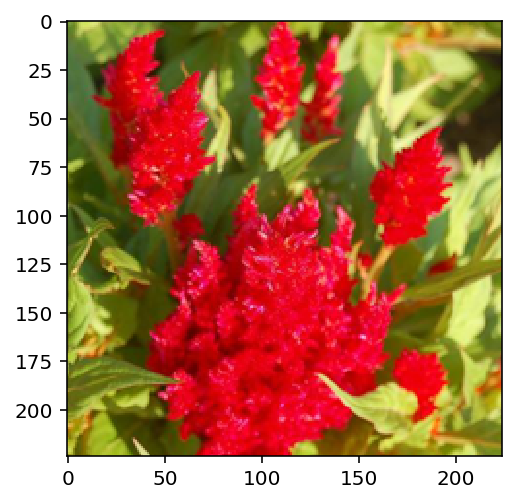

In [26]:
image_path_1 = './flowers/test/27/image_06871.jpg'

# check that image exists
if not path.isfile(image_path_1):
    print("Checkpoint path not valid...")
else:
    pil_image_1 = IM.open(image_path_1)
    processed_image_1 = process_image(pil_image_1)
    imshow(processed_image_1);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [27]:
# Define method to predict the class of a given image
def predict(_image_path, _model, _topk=5, _class_to_idx=None, _device='cpu'):
    _model = _model.to(_device)
    _image = IM.open(_image_path)
    
    # make a tensor transformer and a resize transformer
    tensor_transform = transforms.ToTensor()
    resize_transform = transforms.Resize([224, 224])
    
    # and apply them to the PIL image
    _transformed_image = tensor_transform(resize_transform(_image))
    
    # get the probability from the forward pass
    with torch.no_grad():
        _transformed_image = _transformed_image.unsqueeze(0)
        _transformed_image = _transformed_image.to(_device)
        _logits = _model.forward(_transformed_image)
    
    # because of the NLLLoss()
    _ps = torch.exp(_logits)
    
    # this has the highest prob at index 0, hence the [0], and the index of each probability at index 1
    _ps_topk = _ps.topk(_topk, sorted=True) # sorting in descending order
    _ps_topk_probs = _ps_topk[0] # this is the highest prob at index 0
    _ps_topk_index = _ps_topk[1] # this is the index of each prob at index 1
    
    # Only take the indices that are part of the topk probabilities.
    _idx_to_class = { i: c for c, i in _class_to_idx.items() if i in _ps_topk_index.cpu().numpy() }
    
    return _ps_topk_probs.cpu().numpy().tolist()[0], list(_idx_to_class.values())

In [28]:
probs_1, classes_1 = predict(
    _image_path=image_path_1,
    _model=model,
    _class_to_idx=loaded_checkpoint['class_to_idx'],
    _device=device
)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

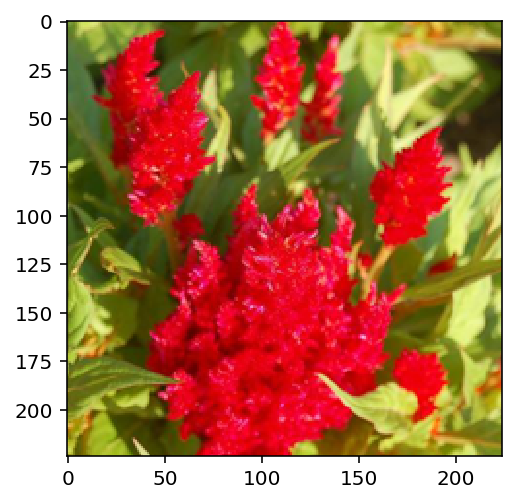

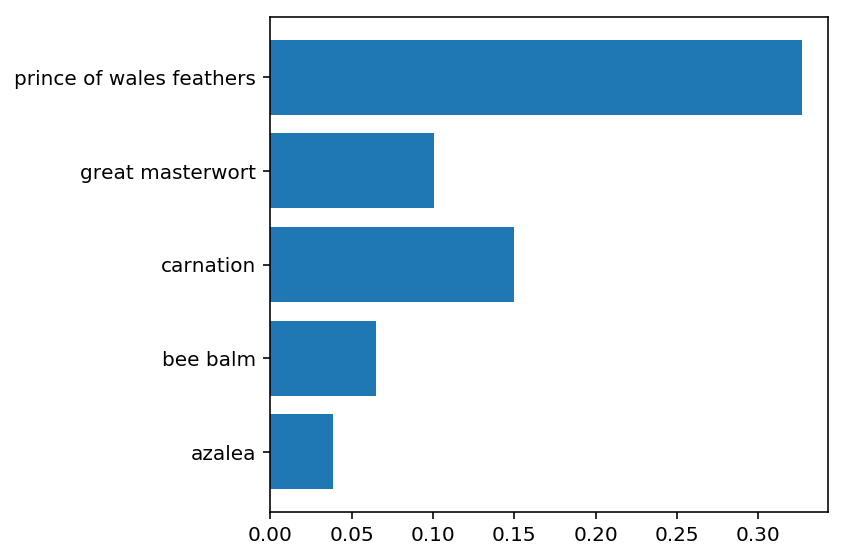

In [29]:
# Display an image along with the top 5 classes
names_1 = [ cat_to_name[k] for k in cat_to_name if k in classes_1 ]

imshow(processed_image_1);

plt.figure(figsize=[5, 10])
plt.subplot(2, 1, 2)
plt.barh(y=names_1, width=probs_1);